# View Sod Shock Tube Results

In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.append('/Users/smil/Projects/cato/scripts/')
from load_datasets import load_1d_dataset
sns.set_context('talk')

cell_dims (400, 3)
398 399 1


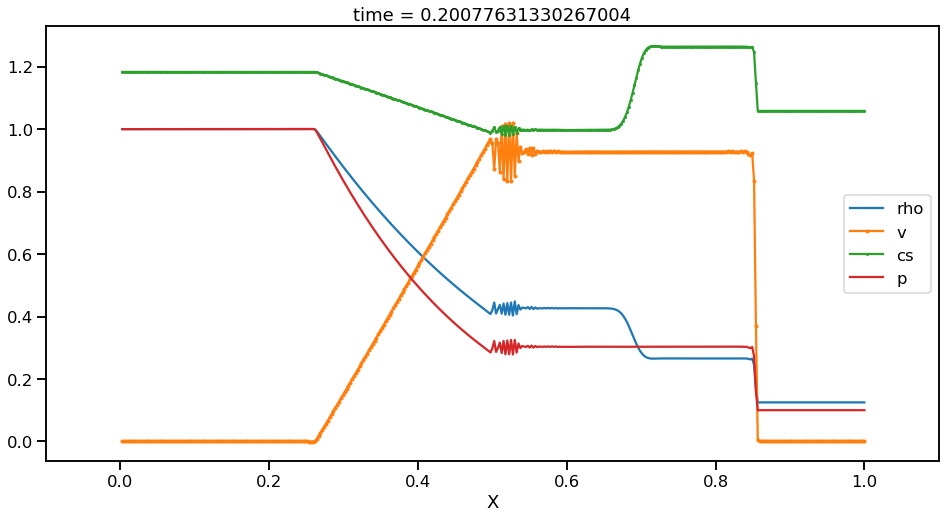

In [7]:
t=.2
import sod
import matplotlib.pyplot as plt
gamma = 1.4
npts = 400

positions, regions, values = sod.solve(left_state= (1,       1, 0), 
                                       right_state=(0.1, 0.125, 0.),
                                       geometry=(0., 1., 0.5), 
                                       t=t, gamma=gamma, npts=npts)

p = values['p']
rho = values['rho']
u = values['u']

# Energy and temperature
E = p/(gamma-1.) + 0.5*u**2
T = p/rho

import seaborn as sns
sns.set_context('talk')

# plt.figure(figsize=(18,10))
plt.figure(figsize=(16,8))

# plt.plot(values['x'], rho, linewidth=1.5, color='r', label='Exact')
# plt.ylabel('density')

ds = load_1d_dataset(folder='.', units='cgs')
gamma = 1.4
# ds['Sound Speed'] = np.sqrt(1.4*ds.pressure/ds.density)
ds['mach'] = ds.velocity/ds.sound_speed

ds.density.sel(time=t, method='nearest').plot(label='rho')
# plt.legend()
# # plt.xlim(.45,.55)
# plt.show()

# plt.figure(figsize=(18,10))
# plt.plot(values['x'], p, linewidth=1.5, color='r', label='Exact')
# plt.ylabel('pressure')

ds.velocity.sel(time=t, method='nearest').plot(marker='o',ms=3,label='v')
ds.sound_speed.sel(time=t, method='nearest').plot(marker='o',ms=2,label='cs')

ds.pressure.sel(time=t, method='nearest').plot(label='p')
# plt.legend()
# # plt.xlim(.45,.55)
# plt.show()

# plt.figure(figsize=(18,10))
# plt.plot(values['x'], u, linewidth=1.5, color='r', label='Exact')
# plt.ylabel('density')
# plt.title(f'Time: {t}')
plt.legend()
plt.xlabel('X')
plt.ylabel('')
# plt.xlim(.45,.55)
# plt.ylim(0,1.75)
plt.xlim(-.1,1.1)

plt.show()